# LangGraph ToolNode

- Author: [JoonHo Kim](https://github.com/jhboyo)
- Design: []()
- Peer Review :
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/04-CSV-Loader.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/04-CSV-Loader.ipynb)


## Overview
In this tutorial, we will cover how to use `LangGraph`'s pre-built `ToolNode` for tool invocation.
`ToolNode` is a `LangChain Runnable` that takes a graph state containing a list of messages as input and updates the state with the result of the tool invocation.

It is designed to work seamlessly with `LangGraph`'s pre-built agents and can operate with any `StateGraph`, provided the state includes a messages key with an appropriate reducer.


Now, let’s explore how to maximize productivity using `LangGraph ToolNode`. 🚀

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Define tools](#define-tools)
- [Manually call ToolNode](#manually-call-toolnode)
- [Using with LLMs](#using-with-llms)
- [Using with Agent](#using-with-agent)

### References

- [How to call tools using ToolNode](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/)
- [ToolNode](https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/prebuilt/tool_node.py)
- [Tool Calling](https://python.langchain.com/docs/concepts/tool_calling/)
- [AIMessage](https://python.langchain.com/docs/concepts/messages/#aimessage)
- [ChatOpenAI](https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html)
- [ChatModel](https://python.langchain.com/docs/integrations/chat/)
- [ReAct Implementation](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation)
- [How to handle tool calling errors](https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [2]:
%%capture --no-stderr
%pip install -qU langchain-opentutorial

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "false",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "LangGraph-ToolNode",
        }
    )

In [4]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_community",
        "langchain_core",
        "langchain_experimental",
        "langchain_openai",
        "feedparser",
        "IPython",
    ],
    verbose=False,
    upgrade=False,
)


## Creating tools
Before creating tools, we will build some functions to collect and fetch news from `Google News` for keyword that user input.

You can refer to `Creating Tools` section in [Tool Calling Agent with More LLM Models](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/15-agent/04-agent-more-llms) for more details.

In [5]:
from typing import List, Dict, Optional
from urllib.parse import quote
import feedparser


class GoogleNews:

    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        news_data = feedparser.parse(url)
        return [
            {"title": entry.title, "link": entry.link}
            for entry in news_data.entries[:k]
        ]

    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        if not news_list:
            print("There is no news for the keyword.")
            return []

        result = []
        for news in news_list:
            result.append({"url": news["link"], "content": news["title"]})

        return result

    def search_by_keyword(
        self, keyword: Optional[str] = None, k: int = 3
    ) -> List[Dict[str, str]]:

        if keyword:
            encoded_keyword = quote(keyword)
            url = f"https://news.google.com/rss/search?q={encoded_keyword}&hl=en&gl=US&ceid=US:en"
        else:
            url = f"https://news.google.com/rss?hl=en&gl=US&ceid=US:en"

        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

Now Let's create tools that search News for query and execute python code.

In [6]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from typing import List, Dict

@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

Next, we will explore how to use `ToolNode` to invoke tools.

`ToolNode` is initialized with a list of tools and the following arguments.

* `Args:`
    * `tools`: A sequence of tools that can be invoked by the `ToolNode`.
    * `name`: The name of the `ToolNode` in the graph. Defaults to "tools".
    * `tags`: Optional tags to associate with the node. Defaults to "None".
    * `handle_tool_errors`: How to handle tool errors raised by tools inside the node. Defaults to "True".

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

# Generate tool list
tools = [search_news, python_code_interpreter]

# Initialize ToolNode
tool_node = ToolNode(tools, handle_tool_errors=True)

## Calling ToolNode manually

`ToolNode` operates on graph state with a list of messages.

`AIMessage` is used to represent a message with the role assistant. This is the response from the model, which can include text or a request to invoke tools. It could also include other media types like images, audio, or video though this is still uncommon at the moment.
* `Args:`
    * `content`: The content of the message. Usually a string, but can be a list of content blocks.
    * `tool_calls`: A list of tool calls associated with the message.
        * `name`: The name of the tool to invoke.
        * `args`: The arguments to pass to the tool.
        * `id`: An optional unique identifier for the message, ideally provided by the provider/model that created the message.
        * `type`: The type of the message.

It expects the last message in the list to be an `AIMessage` with `tool_calls` parameter.

Let’s see how to manually invoke `ToolNode`.

In [8]:
from langchain_core.messages import AIMessage

# Creating an AI message object with single tool call
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "Tesla new model"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

# Invoke single tool call with created message
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMingFBVV95cUxNSjY3UDQyQ0xaSlNUcDBQV0I3VnBJck9wSkRWdTJ4ZU0yUkQwQm9iVGNaYjRva3ZqTmR3ZHFySU9VQTM5OW04NTNCZm8yZU0tekFYSEhLSmFiNGQ0VlNna1VhQk1aS3Y0ZUc5QllXdjA1Z3VCTVBFUW9iUEJhMHBsWWthWGdiTUw4RnZlNENETXNWXzQ0MGFLUXJYMXpfZ9IBowFBVV95cUxNQXVlRG50cGJxUmZNSkFSbnBua1hkaFhZNi14V25PWkxJRDZPZkhxRDVYV3NnQm1xaWZFMEFMeHhESGtwWFBlOUpueGlTa0NKUlNDV2R3N3VfTi1wWmFNdVhGNE85czd5aU9oOGpmc2xkSWM1Q1JZWXgycXZ1X3lPd0ROTHVEOEVOSWxfMzlLTnltaG1ESjdhMWZvZFYyWC10Y1lR?oc=5", "content": "Tesla starts sales of revamped Model Y in U.S. for about $60,000 - CNBC"}, {"url": "https://news.google.com/rss/articles/CBMijAFBVV95cUxQUDhkX2tIUmRNT1J2VExLYmpsYzNSMlB0cTFIcmg5aUtiVEE2cnhfb1lWOGRCTVR4bjYyMk1TMk0tUDc4d3Y5Y1BKd2o0TjZaWnlEa3JKbjY0djh3M25DX0U5dlFGM0RUcFVidllYaDdFcUFGNjBuYkdtWGM4VlRGQi05TElZX09nTDB6bg?oc=5", "content": "Joe Rogan’s new custom Tesla Model S Plaid looks sick - Electrek.co"}, {"url": "https://news.google.com/rss/articles/CBMilA

Generally, there is no need to manually create an `AIMessage`, as it is automatically generated by all LangChain chat models that support tool invocation.

Additionally, by passing multiple tool invocations to the `tool_calls` parameter of an `AIMessage`, you can perform parallel tool invocations using `ToolNode`.

In [9]:
# Creating an AI message object with multiple tool calls
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "Tesla new model"},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

# Invoke multiple tool calls with created message
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMingFBVV95cUxNSjY3UDQyQ0xaSlNUcDBQV0I3VnBJck9wSkRWdTJ4ZU0yUkQwQm9iVGNaYjRva3ZqTmR3ZHFySU9VQTM5OW04NTNCZm8yZU0tekFYSEhLSmFiNGQ0VlNna1VhQk1aS3Y0ZUc5QllXdjA1Z3VCTVBFUW9iUEJhMHBsWWthWGdiTUw4RnZlNENETXNWXzQ0MGFLUXJYMXpfZ9IBowFBVV95cUxNQXVlRG50cGJxUmZNSkFSbnBua1hkaFhZNi14V25PWkxJRDZPZkhxRDVYV3NnQm1xaWZFMEFMeHhESGtwWFBlOUpueGlTa0NKUlNDV2R3N3VfTi1wWmFNdVhGNE85czd5aU9oOGpmc2xkSWM1Q1JZWXgycXZ1X3lPd0ROTHVEOEVOSWxfMzlLTnltaG1ESjdhMWZvZFYyWC10Y1lR?oc=5", "content": "Tesla starts sales of revamped Model Y in U.S. for about $60,000 - CNBC"}, {"url": "https://news.google.com/rss/articles/CBMijAFBVV95cUxQUDhkX2tIUmRNT1J2VExLYmpsYzNSMlB0cTFIcmg5aUtiVEE2cnhfb1lWOGRCTVR4bjYyMk1TMk0tUDc4d3Y5Y1BKd2o0TjZaWnlEa3JKbjY0djh3M25DX0U5dlFGM0RUcFVidllYaDdFcUFGNjBuYkdtWGM4VlRGQi05TElZX09nTDB6bg?oc=5", "content": "Joe Rogan’s new custom Tesla Model S Plaid looks sick - Electrek.co"}, {"url": "https://news.google.com/rss/articles/CBMilA

## Using with LLMs

 To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. 
 LangChain provides various chat models of different providers such as `OpenAI GPT`, `Anthropic Claude`, `Google Gemini` and more.
 You can visit [LangChain ChatModels](https://python.langchain.com/docs/integrations/chat/) for more details.
 
In this tutorial, We do this by calling `.bind_tools` method on `ChatOpenAI` model.
This can be done by calling the `.bind_tools` method on the `ChatOpenAI` model.

In [10]:
from langchain_openai import ChatOpenAI

# Initialize LLM model and bind tools
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [11]:
model_with_tools.invoke(
    "Write Python code to print the first 5 prime numbers."
).tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def is_prime(n):\n    if n <= 1:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprimes = []\nnum = 2\nwhile len(primes) < 5:\n    if is_prime(num):\n        primes.append(num)\n    num += 1\n\nprint(primes)'},
  'id': 'call_izRKAOviyEZpHGYmTPqOaz0z',
  'type': 'tool_call'}]

As you can see, the AI message generated by the chat model already has `tool_calls` populated, so we can just pass it directly to `ToolNode`.

In [12]:
# Processing messages through ToolNode and generating tool-based responses from LLM model
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "Write Python code to print the first 5 prime numbers."
            )
        ]
    }
)

{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]\n', name='python_code_interpreter', tool_call_id='call_3NCmJT0R6JPKulLwG0qPqp9T')]}

## Using with Agent

Next, let's explore how to use `ToolNode` within a `LangGraph`' graph.

We will set up an [`ReAct Agent`](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation)'s graph implementation. This agent takes a query as input and repeatedly invokes tools until it gathers enough information to resolve the query.

Before we start, let's define a function to visualize the graph.

In [13]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

 # Graph visualization
def visualize_graph(graph, xray=False):
    """
    Visualizes and displays a CompiledStateGraph object.
    
    This function converts and displays the given graph object as a PNG image in Mermaid format if it is an instance of CompiledStateGraph.

    Args:
        graph: The graph object to visualize. It must be an instance of CompiledStateGraph.

    Returns:
        None

    Raises:
        Exception: Outputs an exception if an error occurs during graph visualization.
    """
    try:
        if isinstance(graph, CompiledStateGraph):
            display(
                Image(
                    graph.get_graph(xray=xray).draw_mermaid_png(
                        background_color="white",
                        node_colors=None,
                    )
                )
            )
    except Exception as e:
        print(f"[ERROR] Visualize Graph Error: {e}")

The `ToolNode` and `OpenAI` model will be used together with the tools we just defined.

Let's build a graph with the following steps.
1. Use LLM model to process messages and generate responses, return responses with tool calls.
2. Initialize workflow graph based on message state.
3. Define the two nodes we will cycle between agent and tools.
4. Connect the workflow starting point to the agent node.
5. Set up conditional branching from the agent node, connecting to a tool node or an endpoint.
6. Set up circular edges between the tool node and the agent node.
7. Connect the agent node to the end point.
8. Compile the defined workflow graph and create an executable application.

In [14]:
# Import types for LangGraph workflow state and message processing
from langgraph.graph import StateGraph, MessagesState, START, END


# 1. Use LLM model to process messages and generate responses, return responses with tool calls
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 2. Initialize workflow graph based on message state
workflow = StateGraph(MessagesState)

# 3. Define the two nodes we will cycle between agent and tools
# Add agent and tools nodes to the workflow graph
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 4. Connect the workflow starting point to the agent node
workflow.add_edge(START, "agent")

# 5.Set up conditional branching from the agent node, connecting to a tool node or an endpoint
workflow.add_conditional_edges("agent", tools_condition)

# 6. Set up circular edges between the tool node and the agent node
workflow.add_edge("tools", "agent")

# 7. Connect the agent node to the end point
workflow.add_edge("agent", END)

# 8. Compile the defined workflow graph and create an executable application
app = workflow.compile()

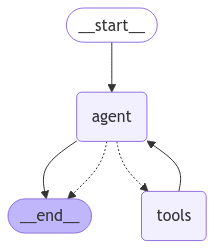

In [15]:
visualize_graph(app)

Let's try to run the graph with different queries.

In [16]:
for chunk in app.stream(
    {"messages": [("human", "Write Python code to print the first 5 prime numbers.")]},
    stream_mode="values",
):
    # Print the last message
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Write Python code to print the first 5 prime numbers.
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_xYrazUEJHCaoBRGPYm3wZvyU)
 Call ID: call_xYrazUEJHCaoBRGPYm3wZvyU
  Args:
    code: def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
num = 2
while len(primes) < 5:
    if is_prime(num):
        primes.append(num)
    num += 1

print(primes)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]

================================== Ai Message ==================================

The first 5 prime numbers are: [2, 3, 5, 7, 11].


In [17]:
# Search query
for chunk in app.stream(
    {"messages": [("human", "What is most played BTS song?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is most played BTS song?
================================== Ai Message ==================================

The most played BTS song is "Dynamite." Released in August 2020, it became a global hit and topped charts worldwide, including the Billboard Hot 100. The song's catchy melody and upbeat vibe contributed to its massive popularity, leading to billions of streams on various platforms. Other popular BTS songs include "Butter," "Boy With Luv," and "Fake Love," but "Dynamite" remains one of their most iconic tracks.


In [18]:
# Query that does not require tool call
for chunk in app.stream(
    {"messages": [("human", "Hi, How's it going?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, How's it going?
================================== Ai Message ==================================

I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?


`ToolNode` can also handle errors that occur during tool execution.

You can enable/disable this feature by setting `handle_tool_errors=True` (enabled by default).